In [1]:
# テキストをリスト単位で取り込み、リスト単位で形態素解析

import MeCab
import fitz
import re

doc = fitz.open("data/pana_ar2023j_a4.pdf") # ドキュメントを開く

#ページ単位でテキストをリストに格納
#page_textにはインデックスは付与されていない
page_text=[]
for page in doc:
    text = page.get_text() # プレーンテキストを取得
    #if text != '' :
        #無駄な改行を削除の上で'。'で改行、一文の範囲を明確にする
    text = re.sub(r'。','。\n', re.sub(r'\n','', text))
        #リストに格納
    page_text.append(text)


In [2]:
print(page_text[5])

パナソニックグループについて　￨　トップメッセージ　￨　セグメント別戦略　￨　テーマ別戦略　￨　コーポレート・ガバナンス　￨　企業データ5Panasonic Holdings   統合報告書2023At a Glance　　価値創造プロセス　　▶マテリアリティマテリアリティマテリアリティ特定の目的「当社財務への影響」「社会への影響」の２つの側面で、サステナビリティに関する重要な機会とリスクを重要課題（マテリアリティ）として特定しました。
マテリアリティへの取り組みを推進し、新たな事業機会の創出とリスクの低減を図ることで、サステナビリティ経営の向上を図ります。
マテリアリティは、事業環境の変化やステークホルダーとの対話等を踏まえ、適宜見直していきます。
マテリアリティの特定プロセス社会からの要請や予見される将来課題等のうち、当社グループにとって機会とリスクになり得る課題を抽出。
次にこれらについて、当社グループおよびステークホルダーの視点で評価し、11の重要課題を抽出しました。
これらの分析プロセスと抽出した重要課題の妥当性を、社外専門家との対話を通して確認。
当社グループのサステナビリティ経営委員会、グループ経営会議、当社取締役会での検討を経て、マテリアリティを特定しました。
マテリアリティ評価結果当社グループとステークホルダーの観点から重要度を評価し、11項目のマテリアリティを特定しました。
サステナビリティ関連項目の抽出現在・将来のサステナビリティ課題のうち、当社グループにとって機会とリスクになり得る課題を抽出（国際基準・法規制の動向、ステークホルダーの関心事、メガトレンド等の分析に基づく）審議・特定サステナビリティ経営委員会、グループ経営会議、当社取締役会での検討を経て、マテリアリティを特定項目の重要度評価抽出した課題について、「当社財務への影響」「社会への影響」の２つの側面の重要度を、当社グループおよびステークホルダーの視点で評価重要課題の抽出STEP ２の評価結果に基づき、11の重要課題を抽出妥当性の検証分析プロセスおよび抽出した重要課題の妥当性について、サステナビリティの専門家に諮問STEP1STEP5STEP2STEP3STEP4当社財務への影響の重要度感染症・パンデミックへの備え自然災害への備え地政学リスクへの備えサイバーセキュリティ自社のサプライチ

In [3]:
def load_exclusion_list(file_path):
    exclusion_list = []
    try:
        with open(file_path, 'r') as file:
            exclusion_list = [line.strip() for line in file]
    except FileNotFoundError:
        pass
    return exclusion_list

def noise_eliminator(text):
#形態素解析の前に、無駄な記号やヘッダ・フッタ等の文言をテキストから除外

    replaced_text = text

    #exclusion_list処理前に処理する必要のあるもの
    #replaced_text = re.sub(r'[▶]', '', replaced_text)

    exclusion_file = "userdic/exclusion_list.txt"  # 除外する項目を記載したテキストファイル
    exclusion_list = load_exclusion_list(exclusion_file)

    for pattern in exclusion_list:
        replaced_text = re.sub(pattern, ' ', replaced_text)
    
    replaced_text = re.sub(r'P\d+', ' ', replaced_text) 
        
    replaced_text = re.sub(r'[■□▪▫▲△▶▷▸▹▼▽◆◇●〇]', '。\n', replaced_text)#文頭のこれら記号は箇条書きとして一文とみなす扱い
    #replaced_text = re.sub(r'[〇●◇◆□■▶△▲▽▼▫▪▹▶▸]', '', replaced_text)#上記以外は除去
    
    replaced_text = re.sub(r'[【】（）()\[\]]', ' ', replaced_text)
    replaced_text = re.sub(r'[\d\-]+年度末', '', replaced_text)  # 年度末の除去
    replaced_text = re.sub(r'[\d\-]+年度', '', replaced_text)  # 年度の除去
    replaced_text = re.sub(r'\d+[年月日]', '', replaced_text)  # 年月日の除去
    replaced_text = re.sub(r'\d+回', '', replaced_text)  # \d回（取締役の任命回数など）の除去

    replaced_text = re.sub(r'[@＠]\w+', '', replaced_text)  # メンションの除去
    replaced_text = re.sub(r'https?://[\w/;%#\$\&\?\(\)~\.=\+\-]+', '', replaced_text)  # リンクの除去
    #replaced_text = re.sub(r'\d+\.*\d*', '', replaced_text) #　数字を除去
    #replaced_text = text.lower() #　すべて小文字に変換

    return replaced_text


In [4]:
#形態素解析関数（入力：テキスト、出力：リスト）

def mecab_tokenizer(text):

    path1 = "-Ochasen -d /usr/lib/x86_64-linux-gnu/mecab/dic/mecab-ipadic-neologd"
    path2 = " -u /work_dir/userdic/user.dic"
    mecab = MeCab.Tagger(path1+path2)
   
    parsed_lines = mecab.parse(text).split("\n")[:-2]
    #[:-2]で文末の'EOS',''の取り込みを抑制
    #print(parsed_lines)
    
    #形態素の取得（リスト形式）
    #原形を取得
    token_list = [l.split("\t")[2] for l in parsed_lines]
    #表層形を確認したい場合
    #token_list = [l.split('\t')[0] for l in parsed_lines]
    #print(token_list)
    
    #品詞区分による絞り込み
    #--------------------------------------------
    #Chasenの品詞区分を個別に指定する場合
    
    #品詞区分の取得（リスト形式）
    pos = [l.split('\t')[3] for l in parsed_lines]

    #抽出する品詞区分の定義（完全一致で指定）
    target_pos = ['名詞-一般',
                  '名詞-固有名詞-一般',
                  '名詞-固有名詞-人名-一般',
                  '名詞-固有名詞-人名-姓',
                  '名詞-固有名詞-人名-名',
                  '名詞-固有名詞-組織',
                  '名詞-固有名詞-地域-一般',
                  '名詞-固有名詞-地域-国',
                  '名詞-代名詞-一般',
                  '名詞-代名詞-縮約',
                  '名詞-副詞可能',
                  '名詞-サ変接続',
                  '名詞-形容動詞語幹',
                  '名詞-ナイ形容詞語幹'
                 ]
    #--------------------------------------------
    #Chasenの品詞区分の大項目のみで絞り込む場合
    #品詞区分の取得（リスト形式）
    #pos = [l.split('\t')[3].split("-")[0]  for l in parsed_lines]
    
    #絞り込む品詞区分の定義
    #target_pos = ['名詞']
    
    #--------------------------------------------
    #形態素と品詞区分のリストをペアにしてタプルリスト化、該当する品詞区分の形態素のみリストに出力
    token_list = [t for t, p in zip(token_list, pos) if p in target_pos]
    
    #stopwordsの指定
    stopwords = []

    with open("userdic/Japanese.txt","r") as f:
        stopwords1 = f.read().split("\n")
   #stopwordsを直接反映したい場合は以下のリストに記載
    stopwords2 =["以下","ため","当社","当行","場合","影響","可能性",
            "状況","グループ","こと","平成","令和","年","月","期","当","他",
            "等","お","これ","%","以上","もの","株式会社",
            "もの","とも","ある","よる","的","化","お呼び",
            "CEO","会長","社長","副社長","専務","役員","常務","代表社員"
            "代表取締役会長","代表取締役社長","代表取締役","常務取締役","社外取締役","取締役会長","取締役社長",
            "代表執行役員","専務執行役員","常務執行役員","執行役員",
            "取締役","取締役会","監査役","監査役会","議長","所長",
            "担当","100％","100%","株","データ","男性","チーフ","オフィサー","CFO",
            "入社","入所","就任","選任","指名","任命","解任","諮問","答申","ご参照","全体",
            "*"]
    stopwords.extend(stopwords1)
    stopwords.extend(stopwords2)
    # 元の順序を保持しつつ重複を除去（# Python 3.7以降）
    from collections import OrderedDict
    stopwords = list(OrderedDict.fromkeys(stopwords))
    
    # stopwordsの除去
    token_list = [t for t in token_list if t  not in stopwords]
    
    # ひらがなのみの単語を除く
    kana_re = re.compile("^[ぁ-ゖ]+$")
    token_list = [t for t in token_list if not kana_re.match(t)]

    # アルファベット1文字のみの形態素を除外
    alphabet_re = re.compile("^[a-zA-Z]$")
    token_list = [t for t in token_list if not alphabet_re.match(t)]

    return token_list

In [5]:
#ページインデックス付きで、形態素解析結果をページ単位で格納
tokenized_page_text = [(index, mecab_tokenizer(noise_eliminator(item)))for index, item in enumerate(page_text)]
#print(page_text[1])
#print()
#print(tokenized_page_text)

#ページインデックスのないもの
#tokenized_page_text_noindex = [sublist for _, sublist in tokenized_page_text]
#print (tokenized_page_text_noindex)
#ページ単位の形態素解析結果を、一つの要素にマージしたもの
#merged_tokenized_list = [item for _, sublist in tokenized_page_text for item in sublist]
#print (merged_tokenized_list)

In [6]:
print(page_text[5])
print()
print(tokenized_page_text[5])

パナソニックグループについて　￨　トップメッセージ　￨　セグメント別戦略　￨　テーマ別戦略　￨　コーポレート・ガバナンス　￨　企業データ5Panasonic Holdings   統合報告書2023At a Glance　　価値創造プロセス　　▶マテリアリティマテリアリティマテリアリティ特定の目的「当社財務への影響」「社会への影響」の２つの側面で、サステナビリティに関する重要な機会とリスクを重要課題（マテリアリティ）として特定しました。
マテリアリティへの取り組みを推進し、新たな事業機会の創出とリスクの低減を図ることで、サステナビリティ経営の向上を図ります。
マテリアリティは、事業環境の変化やステークホルダーとの対話等を踏まえ、適宜見直していきます。
マテリアリティの特定プロセス社会からの要請や予見される将来課題等のうち、当社グループにとって機会とリスクになり得る課題を抽出。
次にこれらについて、当社グループおよびステークホルダーの視点で評価し、11の重要課題を抽出しました。
これらの分析プロセスと抽出した重要課題の妥当性を、社外専門家との対話を通して確認。
当社グループのサステナビリティ経営委員会、グループ経営会議、当社取締役会での検討を経て、マテリアリティを特定しました。
マテリアリティ評価結果当社グループとステークホルダーの観点から重要度を評価し、11項目のマテリアリティを特定しました。
サステナビリティ関連項目の抽出現在・将来のサステナビリティ課題のうち、当社グループにとって機会とリスクになり得る課題を抽出（国際基準・法規制の動向、ステークホルダーの関心事、メガトレンド等の分析に基づく）審議・特定サステナビリティ経営委員会、グループ経営会議、当社取締役会での検討を経て、マテリアリティを特定項目の重要度評価抽出した課題について、「当社財務への影響」「社会への影響」の２つの側面の重要度を、当社グループおよびステークホルダーの視点で評価重要課題の抽出STEP ２の評価結果に基づき、11の重要課題を抽出妥当性の検証分析プロセスおよび抽出した重要課題の妥当性について、サステナビリティの専門家に諮問STEP1STEP5STEP2STEP3STEP4当社財務への影響の重要度感染症・パンデミックへの備え自然災害への備え地政学リスクへの備えサイバーセキュリティ自社のサプライチ

In [7]:
#形態素を別途用意した対比リストと比較し、対比リスト内の単語が含まれる要素のみを残す
# 対比リストを読込
with open("data/TCFD_Term.txt", "r") as Ref_term:
        Ref_list = list(set(Ref_term.read().split("\n")))
#print(Ref_list)

#対比リストの単語が含まれるページの形態素リスト
Extracted_tokenized_page_text = [(index, sublist) for index, sublist in tokenized_page_text if any(item in Ref_list for item in sublist)]
#該当ページのインデックスリスト
Extracted_tokenized_page_index = [index for index, sublist in tokenized_page_text if any(item in Ref_list for item in sublist)]
#形態素解析前のpage_textの該当ページ部分
Extracted_page_text = [page_text[i] for i in Extracted_tokenized_page_index]

print(Extracted_tokenized_page_index)
#print(Extracted_tokenized_page_text)

[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 28, 29, 30, 33, 37, 39, 42, 43, 49, 50, 51, 52, 53, 54, 55]


In [8]:
#マニュアルで抽出ページを指定
#man_page_index =[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 28, 29, 30, 33, 37, 39, 42, 43, 49, 50, 51, 52, 53, 54, 55]
man_page_index = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 26, 28, 29, 30, 33, 37, 49, 50, 51, 52, 55]
#man_page_index = [2, 3, 4, 6, 12, 13, 15, 16, 20, 21, 22, 23, 24, 25, 26, 27, 28, 36, 42, 49, 50, 51, 53, 55]
#man_page_index = [2, 5, 14, 19, 22, 25, 40, 48, 49, 52]

#抽出ページ単位の形態素リスト
Extracted_tokenized_page_text = [(index, sublist) for index, sublist in tokenized_page_text if index in man_page_index]
#該当ページのインデックスリスト
Extracted_tokenized_page_index = [index for index, sublist in tokenized_page_text if index in man_page_index]
#形態素解析前の抽出ページ単位テキスト
Extracted_page_text = [page_text[i] for i in man_page_index]
#特定のページのみを直接指定するなら、
#Extracted_page_text = [page_text[5]]

#print(Extracted_tokenized_page_index)
#print(Extracted_tokenized_page_text[2])
#print(Extracted_page_text[2])

In [9]:
#抽出されたページのサブリストを一つのリストにまとめる
Merged_Extracted_tokenized_list = [item for _, sublist in Extracted_tokenized_page_text for item in sublist]
#print(merged_Extracted_tokenized_list)

In [10]:
import collections
from collections import Counter
import pandas as pd
import itertools
import datetime

#辞書形式で単語をカウント
counter = Counter(Merged_Extracted_tokenized_list)
#for word, count in counter.most_common(500):
#    print('%s : %s' % (word, count))

# 単語、件数をDataFrameに格納
count_df = pd.DataFrame(list(counter.items()), columns=['単語', '件数'])
# DataFrameを件数でソート
count_df = count_df.sort_values(by='件数', ascending=False)
#ファイル名を指定

# 現在の日付と時刻を取得
now = datetime.datetime.now()
# 年月日と時刻の文字列を生成
date_time_string = now.strftime("%Y%m%d_%H%M%S")
# ファイル名を生成
file_name = f"data/{date_time_string}_Word_list.csv"
# 結果をCSVファイルに出力
count_df.to_csv(file_name, encoding="utf_8_sig", index=False)

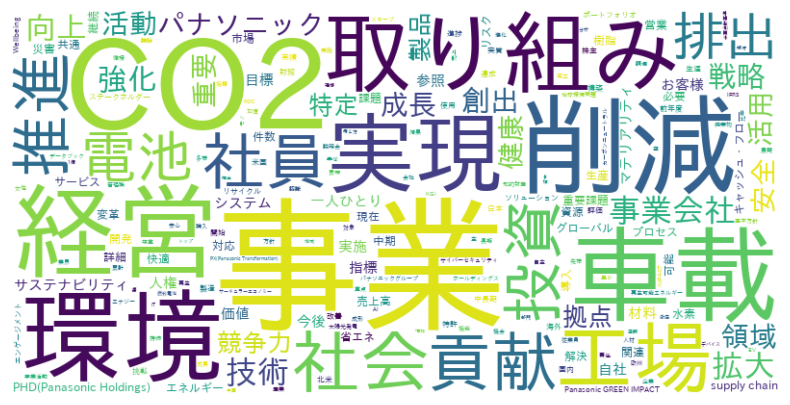

In [11]:
#抽出単語でワードクラウドを作る
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# 日本語フォントのパスを指定
jp_font_path = '/usr/share/fonts/opentype/ipaexfont-gothic/ipaexg.ttf'
#'/path/to/your/font.ttf'  # あなたのシステムにインストールされている日本語フォントのパスを指定してください

# ワードクラウドの生成
wordcloud = WordCloud(width=800, height=400, background_color='white',font_path=jp_font_path)

# 単語とその頻度を辞書形式に変換
word_freq = {word: freq for word, freq in zip(count_df['単語'], count_df['件数'])}

# ワードクラウドの生成
wordcloud.generate_from_frequencies(word_freq)

# プロット
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# 画像として保存
file_name_wordcloud=f'data/{date_time_string}_WordCloud.png'
wordcloud.to_file(file_name_wordcloud)

In [12]:
#以降、共起分析

#Extracted_page_text（抽出ページ単位のリスト）を、要素一つのリストに集約
Merged_Extracted_page_text = "\n\n".join(Extracted_page_text)
#print(noise_eliminator(Merged_Extracted_page_text))

In [13]:
#集約したテキストを「。」で区切り、形態素解析（共起分析用）
sentences = [mecab_tokenizer(sentence) for sentence in re.split("。", noise_eliminator(Merged_Extracted_page_text))]
#sentences = [mecab_tokenizer(sentence) for sentence in re.split("。|\n", noise_eliminator(Merged_Extracted_page_text))]

#print(sentences)

In [14]:
#各文中の、形態素組み合わせを作る
sentences_combs = [list(itertools.combinations(sentence,2)) for sentence in sentences]
#print(sentences_combs[0])

#組み合わせた2つの形態素の並びをソート
words_combs = [[tuple(sorted(words)) for words in sentence] for sentence in sentences_combs]
#print(words_combs[0][:30])

target_combs = []
for words_comb in words_combs:
    target_combs.extend(words_comb)
#print(target_combs[:30])

ct = collections.Counter(target_combs)
#print(ct)

#import pandas as pd
df = pd.DataFrame([{"1番目" : i[0][0], "2番目": i[0][1], "count":i[1]} for i in ct.most_common()])
df.head(30)

# 現在の日付と時刻を取得
#now = datetime.datetime.now()
# 年月日と時刻の文字列を生成
#date_time_string = now.strftime("%Y%m%d_%H%M%S")
# ファイル名を生成
# date_timeはWordlistと同じにしておく
file_name_comb = f"data/{date_time_string}_Co_count_result_.csv"
df.to_csv(file_name_comb, encoding="utf_8_sig", index=False)

In [15]:
#ネットワーク分析の下準備
import networkx as nx
from networkx.algorithms.community import girvan_newman
from pyvis.network import Network
import random
#import matplotlib
#import matplotlib.pyplot as plt
#plt.rcParams['font.family'] = 'IPAexGothic'  # 使用するフォントを指定（例：IPAexGothic）
#import japanize_matplotlib
#japanize_matplotlib.japanize()


In [16]:
#########################################################
# 分析対象とする共起単語の組み合わせ数（ノード数）を指定
analyzed_nodes=600
limited_df=df.head(analyzed_nodes)
#########################################################

In [17]:
# DataFrameからネットワークを作成
G = nx.from_pandas_edgelist(limited_df, '1番目', '2番目', ['count'])
#print(G)

# 各ノードの中心性を計算
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)
#katz_centrality = nx.katz_centrality(G)

# Girvan-Newmanアルゴリズムでコミュニティに分割
comp = girvan_newman(G)
communities = tuple(sorted(c) for c in next(comp))

# 各ノードがどのコミュニティに属するかを記録
community_map = {}
for i, community in enumerate(communities):
    for node in community:
        community_map[node] = i

# 中心性を新しいデータフレームに格納
centrality_df = pd.DataFrame({
    'Node': list(G.nodes()),
    'Degree Centrality': [degree_centrality[node] for node in G.nodes()],
    'Betweenness Centrality': [betweenness_centrality[node] for node in G.nodes()],
    'Closeness Centrality': [closeness_centrality[node] for node in G.nodes()],
    'Eigenvector Centrality': [eigenvector_centrality[node] for node in G.nodes()],
#    'Katz Centrality': [katz_centrality[node] for node in G.nodes()],
    'Community': [community_map[node] for node in G.nodes()]  # コミュニティ情報を追加
})
#print(centrality_df)

file_name_comb = f"data/{date_time_string}_Centrality_{analyzed_nodes}.csv"
centrality_df.to_csv(file_name_comb, encoding="utf_8_sig", index=False)

In [18]:
#ネットワーク図の描画
#ここではpyvisを使用

class ColoredObject:
    def __init__(self, color):
        self.color = color
# 12種類の色を用意
colors = ["#CBCCCD", "red", "blue", "green", "#A2CEF6", "magenta", "brown",  "yellow", "orange", "purple", "#EDABE5", "black" ]
# 色の順番を追跡するためのインデックス
color_index = 0
# 色を順番に取得する関数
def choose_color():
    global color_index
    color = colors[color_index]
    color_index = (color_index + 1) % len(colors)  # インデックスを更新し、13番目の場合は最初の色に戻る
    return color

def kyoki_word_network(df):

    #Girvan-Newmanアルゴリズムによるコミュニティ分割（networkxの機能）
    G = nx.from_pandas_edgelist(df, '1番目', '2番目', ['count'])
    comp = girvan_newman(G)
    communities = tuple(sorted(c) for c in next(comp))

    #各コミュニティに色を割り当てる
    color_map = {}
    for i, community in enumerate(communities):
        color = choose_color() #"#{:06x}".format(random.randint(0, 0xFFFFFF))  # ランダムな色を生成
        for node in community:
            color_map[node] = color
    
    
    got_net = Network(height="1000px", width="95%", bgcolor="#FFFFFF", font_color="black", notebook=True)

    got_net.force_atlas_2based()
    got_data = df

    sources = got_data['1番目']
    targets = got_data['2番目']
    weights = got_data['count']

    edge_data = zip(sources, targets, weights)

    for e in edge_data:
        src = e[0]
        dst = e[1]
        w = e[2]
        got_net.add_node(src, src, title=src, color=color_map.get(src, None))
        got_net.add_node(dst, dst, title=dst, color=color_map.get(dst, None))
        got_net.add_edge(src, dst, value=w)

    # コミュニティごとにノードの色を設定
    for node, color in color_map.items():
        got_net.add_node(node, color=color)

    neighbor_map = got_net.get_adj_list()

    for node in got_net.nodes:
        node["title"] += " Neighbors:<br>" + "<br>".join(neighbor_map[node["id"]])
        node["value"] = len(neighbor_map[node["id"]])

    got_net.show_buttons(filter_=['physics'])
    return got_net

In [19]:
got_net = kyoki_word_network(limited_df)
file_name_kyoki = f'data/{date_time_string}_kyoki_{analyzed_nodes}.html'
got_net.show(file_name_kyoki)